# NetMorph
http://www.scholarpedia.org/article/NETMORPH
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085858
https://link.springer.com/article/10.1007/s12021-009-9052-3
https://jvanpelt.nl/

- diameterは省略．
- netmorph -> vision map
- 本書では取り扱わないが，層構造や脳の全体のシミュレーションもある．

### 分岐
時刻$[t_i, t_i + \Delta t]$において，$j$番目の末端分節(terminal segment)が分岐する確率は
$$
p_{i,j} = n_i^{-E}\cdot B_{\infty} e^{\frac{-t_i}{\tau}} \left(e^{\frac{\Delta t}{\tau}} - 1\right)\cdot \frac{2^{-S\gamma_j}}{C_{n_i}}
$$
で表される．ここで，$B_{\infty}, E, S, \tau$は定数である．$\gamma_j$は$j$番目の末端分節の階層(centrifugal order)であり，$n_i$は時刻$t_i$における末端分節の総計である．さらに

$$
{C_{n_i}} = \frac{1}{n_i}\sum\nolimits_{k = 1}^{n_i} {{2^{ - S{\gamma_k}}}}
$$

とする．

### 伸長と角度

### 分岐時の角度と長さ
平行四辺形？

$$
\begin{align}
x &= r \sin\theta \cos\phi\\
y &= r \sin\theta \sin\phi\\
z &= r \cos\theta
\end{align}
$$

### ToDo
- 分岐時の角度（平行四辺形）
- 角度の上限 
- 3D化は読者に任せる？

In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using PyPlot, ProgressMeter, Distributions
rc("axes.spines", top=false, right=false)

In [2]:
function branching_prob(t, dt, γ, n, C, B∞, E, S, τ)
    return (n^(-E))*B∞*exp(-t/τ)*(exp(dt/τ) - 1)*(2^(-S*γ))/C
end

branching_prob (generic function with 1 method)

- tree_info (Int): 接続している分節の番号, 階層， 末端かどうかboolean
- seg_vec (Float): 分節のベクトル(x, y) -> (angle, length)

In [3]:
function segments_lines(tree_info, seg_vec)
    num_segments = size(tree_info)[1]
    
    pos = zeros(num_segments, 2);
    for j in 1:num_segments
        pos[j, :] = pos[tree_info[j][1], :] + seg_vec[j][1] * [cos(seg_vec[j][2]), sin(seg_vec[j][2])]
    end
    
    lines = []
    for j in 1:num_segments
        x1, y1 = pos[tree_info[j][1], :]
        x2, y2 = pos[j, :]
        push!(lines, [(x1, y1), (x2, y2)])
    end
    return lines
end

segments_lines (generic function with 1 method)

In [24]:
function simulation(tree_info_init, seg_vec_init, nt, dt, B∞, E, S, τ, μₑ, σₑ)
    tree_info = copy(tree_info_init)
    seg_vec = copy(seg_vec_init)
    num_branching = 0
    
    """
    if size(seg_vec_init[1])[1] == 2
        vecdim = "2d"
    else
    """
    
    @showprogress for tt in 1:nt
        t = tt*dt
        n, C = 0.0, 0.0
        for j in 1:size(tree_info)[1]
            if tree_info[j][3] == 1
                n += 1
                C += 2 ^(-S*tree_info[j][2])
            end
        end
        C /= n
        for j in 1:size(tree_info)[1]
            if tree_info[j][3] == 1
                γ = tree_info[j][2]
                p = branching_prob(t, dt, γ, n, C, B∞, E, S, τ)
                if p > rand()
                    # Neurite branching
                    num_branching += 1
                    branch_lens = (μₑ .+ randn(2) * σₑ)*dt　# branch length
                    branch_angles = Float64[rand(Uniform(0, π)*0.1)]
                    push!(branch_angles, -branch_angles[1]) 
                    #branch_angles = Float64[rand(Uniform(-π, π)*1e-2)]
                    #push!(branch_angles, asin(-branch_lens[1]*sin(branch_angles[1])/branch_lens[2])) # 平行四辺形を作る
                    for k in 1:2
                        tree_info = push!(tree_info, [j, γ+1, 1]) # add two branches
                        seg_vec = push!(seg_vec, [branch_lens[k], seg_vec[j][2]+branch_angles[k]])
                    end
                else
                    # Neurite elongation
                    tree_info = push!(tree_info, [j, γ, 1]) # add segment
                    seg_len = (μₑ .+ randn() * σₑ)*dt
                    seg_angle = seg_vec[j][2] + rand(Uniform(-π, π)*5e-3)
                    seg_vec = push!(seg_vec, [seg_len, seg_angle])
                end
                tree_info[j][3] = 0 # reset centrifugal order of original branch
            end
        end
    end
    println("Num. branching: ", num_branching)
    return tree_info, seg_vec
end

simulation (generic function with 1 method)

In [25]:
# axon
B∞=13.2; E=0.319; S=-0.205; τ=1681541; dt=200; 
μₑ = 2.14e-4; σₑ = 3.98e-4;

# basal dendrite
#B∞=2.52; E=0.73; S=0.5; τ=259680; dt=200; 
#μₑ = 9.14e-5; σₑ = 3.66e-5;
T = 18*24*60*60 # 18 days to sec
nt = round(Int, T/dt);

配列にcatするよりlist化してpush!の方が高速．

In [ ]:
"""
num_initial_branches = 1
tree_info_init = Vector{Int64}[[1, 0, 0]]
seg_vec_init = Vector{Float64}[[0.0, 0.0]]

init_branch_lens = (μₑ .+ randn(num_initial_branches) * σₑ)*dt
init_branch_angles = rand(Uniform(0, 2π), num_initial_branches)

for k in 1:num_initial_branches
    tree_info_init = push!(tree_info_init, [1, 0, 1])
    seg_vec_init = push!(seg_vec_init, [init_branch_lens[k], init_branch_angles[k]])
end
"""

In [26]:
tree_info_init = Vector{Int64}[[1, 0, 0], [1, 0, 1]]
seg_vec_init = Vector{Float64}[[0.0, 0.0], [μₑ, π/2]]

@time tree_info, seg_vec = simulation(tree_info_init, seg_vec_init, nt, dt, B∞, E, S, τ, μₑ, σₑ);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Num. branching: 66
  4.458642 seconds (2.23 M allocations: 135.904 MiB, 1.91% gc time, 8.45% compilation time)


In [27]:
lines = segments_lines(tree_info, seg_vec);

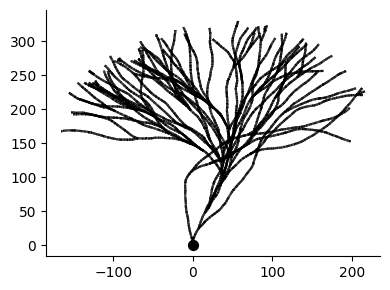

In [28]:
figure(figsize=(4, 3))
line_segments = matplotlib.collections.LineCollection(lines, color="k")
PyPlot.axes().add_collection(line_segments)
scatter(0, 0, s=50, color="k")
tight_layout()